In [2]:
# Se importan los paquetes necesarios:

import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import math
from dateutil.relativedelta import relativedelta

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
cd \Users\mbpablo\Desktop\TFM\Ficheros_entrada\

C:\Users\mbpablo\Desktop\TFM\Ficheros_entrada


## 1. Importación mensual del fichero:

In [4]:
# Se visualizan todas las variables del dataset

pd.set_option('display.max_columns', 500)

In [5]:
list_of_data = ('ENE','FEB','MAR','ABR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC')

In [6]:
# Se importan los ficheros mensuales:

def import_data(list_of_data):
    
    """ Se crea un fichero donde se irán acumulando las extracciones mensuales.
    Se elige esta manera de hacerlo porque no todos los meses tienen la misma estructura de variables """
  
    datos = []
  
    for file in list_of_data:

        datos.append(pd.read_csv(file + '_v2_2018.tab', 
           sep='\t', encoding='latin-1', engine='python', error_bad_lines=False, 
           na_values=[np.nan, 'nan', 'NONE', -999, ''], parse_dates=['VAR_27','VAR_28']))
    
        df = pd.concat(datos, sort=True)
    
    return df

In [7]:
A = import_data(list_of_data)
A.head(5)

,VAR_01,VAR_02,VAR_03,VAR_04,VAR_05,VAR_06,VAR_07,VAR_08,VAR_09,VAR_10,VAR_11,VAR_12,VAR_13,VAR_14,VAR_15,VAR_16,VAR_17,VAR_18,VAR_19,VAR_20,VAR_21,VAR_22,VAR_23,VAR_24,VAR_25,VAR_26,VAR_27,VAR_28,VAR_29,VAR_30,VAR_31,VAR_32,VAR_33,VAR_34,VAR_35,VAR_36,VAR_37,VAR_38,VAR_39,VAR_40,VAR_41,VAR_42,VAR_43,VAR_44,VAR_45,VAR_46,VAR_47,VAR_48,VAR_49,VAR_50,VAR_51,VAR_52,VAR_53,VAR_54,VAR_55,VAR_56,VAR_57,VAR_58,VAR_59,VAR_60,VAR_61,VAR_62,VAR_63,VAR_64,VAR_65,VAR_66,VAR_67,VAR_68,VAR_69,VAR_70,VAR_71,VAR_72,VAR_73,VAR_74,VAR_75,VAR_76,VAR_77,VAR_78,VAR_79,VAR_80,VAR_81,VAR_82,VAR_83,VAR_84,VAR_85,VAR_86,VAR_87,VAR_88,VAR_89,VAR_90,VAR_91,VAR_92,VAR_93,VAR_94
0,1,3 años,Question Not Shown To Visitor,Entre 4 y 5 años,3 años,3 años,1.0,1,1,26 25 años,1,28018,100001,1,0,0,0,0,0,1,1,1.0,1,0,0,0,2018-01-15,1974-05-14,Este mes,1,1,0,0,0,NaN,1,2,3,1,1,28,0,O,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,11.0,0,0,0,1
1,2,más de 10,Question Not Shown To Visitor,Entre 10 y 25 años,más de 10,más de 10,0.0,2,2,24 23 años,1,7141,100009,2,1,0,0,0,0,1,2,1.0,0,1,0,1,2018-01-19,1976-08-23,Hace 11 meses,1,2,0,0,0,NaN,1,2,1,2,1,7,0,L,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,7.0,0,0,0,1
2,2,más de 10,Question Not Shown To Visitor,Entre 10 y 25 años,Sin Accidentes,más de 10,0.0,2,3,18 17 años,1,10005,100009,3,0,0,0,0,0,1,2,NaN,0,0,0,1,2018-08-01,1981-01-23,Dentro de 1 mes,0,3,0,0,0,NaN,1,1,1,3,1,10,0,L,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,7,1,1,8.0,0,0,0,1
3,2,más de 10,Question Not Shown To Visitor,Entre 2 y 3 años,4 años,más de 10,0.0,1,4,25 24 años,1,8222,100011,3,0,0,0,0,0,0,1,1.0,0,0,0,1,2018-11-01,1975-05-11,Este mes,1,4,0,0,1,NaN,1,1,1,4,1,8,0,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,9.0,0,0,0,1
4,3,1 año,0 Years and 10 Months,Entre 10 y 25 años,2 años,1 años,1.0,1,5,10 9 años,1,4009,100016,4,0,0,0,0,0,0,1,1.0,0,0,0,1,2018-01-22,1990-05-30,Dentro de 2 meses,0,2,1,0,0,NaN,1,2,1,5,1,4,0,J,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,1,2,9.0,0,0,0,1


In [8]:
A.dtypes

VAR_01             int64
VAR_02            object
VAR_03            object
VAR_04            object
VAR_05            object
VAR_06            object
VAR_07           float64
VAR_08             int64
VAR_09             int64
VAR_10            object
VAR_11             int64
VAR_12             int64
VAR_13             int64
VAR_14             int64
VAR_15             int64
VAR_16             int64
VAR_17             int64
VAR_18             int64
VAR_19             int64
VAR_20             int64
VAR_21             int64
VAR_22           float64
VAR_23             int64
VAR_24             int64
VAR_25             int64
VAR_26             int64
VAR_27    datetime64[ns]
VAR_28    datetime64[ns]
VAR_29            object
VAR_30             int64
               ...      
VAR_65             int64
VAR_66             int64
VAR_67             int64
VAR_68             int64
VAR_69             int64
VAR_70             int64
VAR_71             int64
VAR_72             int64
VAR_73             int64


In [9]:
# Se definen como string las variables que van a ser tratadas como categóricas:
      
dtype_columns = ['VAR_01', 'VAR_08', 'VAR_09', 'VAR_11', 'VAR_12', 'VAR_13', 'VAR_14', 'VAR_15', 'VAR_16', 'VAR_17', 
                 'VAR_18', 'VAR_19', 'VAR_20', 'VAR_21', 'VAR_22', 'VAR_23', 'VAR_24', 'VAR_25', 'VAR_26', 'VAR_30',
                 'VAR_31', 'VAR_35', 'VAR_36', 'VAR_38', 'VAR_39', 'VAR_40', 'VAR_41', 'VAR_42', 'VAR_44', 'VAR_45',
                 'VAR_46', 'VAR_47', 'VAR_48', 'VAR_49', 'VAR_50', 'VAR_51', 'VAR_52', 'VAR_53', 'VAR_54','VAR_55',
                 'VAR_56', 'VAR_57', 'VAR_58', 'VAR_59', 'VAR_60', 'VAR_61', 'VAR_62', 'VAR_63', 'VAR_64','VAR_65',
                 'VAR_66', 'VAR_67', 'VAR_68', 'VAR_69', 'VAR_70', 'VAR_71', 'VAR_72', 'VAR_73', 'VAR_74','VAR_75',
                 'VAR_76', 'VAR_77', 'VAR_78', 'VAR_79', 'VAR_80', 'VAR_81', 'VAR_82', 'VAR_83', 'VAR_84','VAR_85',
                 'VAR_86', 'VAR_88', 'VAR_89', 'VAR_90', 'VAR_94']
      
A.loc[:, dtype_columns] = A.loc[:, dtype_columns].astype('str')

In [10]:
A.shape

(108406, 94)

In [11]:
# Se comprueba que la importación de los ficheros mensuales no haya generado registros duplicados:

A.shape[0] == A.drop_duplicates().shape[0]

True

### 1.2 Se añade información adicional procedente del catálogo:

In [12]:
T_CATALOGO = pd.read_csv('CATALOGO_v2_112018_TFM.txt', sep='\t', engine='python')

dtype_cat_columns = ['VAR_13', 'VAR_95', 'VAR_96', 'VAR_97', 'VAR_98', 'VAR_101', 'VAR_103']

T_CATALOGO.loc[:, dtype_cat_columns] = T_CATALOGO.loc[:, dtype_cat_columns].astype('str')

T_CATALOGO.head(2)

,VAR_13,VAR_95,VAR_96,VAR_97,VAR_98,VAR_99,VAR_100,VAR_101,VAR_102,VAR_103,VAR_104,VAR_105
0,1,4,0.0,5,5,1569,74,0.0,0,0,5553.35,0
1,2,2,0.0,5,5,1490,95,0.0,0,0,12020.24,0


In [13]:
# Se añade información adicional procedente del catálogo:

A_cat = A.merge(T_CATALOGO, how='left', left_on=['VAR_13'], right_on=['VAR_13'])

# Se comprueba que el cruce es correcto, ya que el dataset de salida tiene las mismas columnas del de entrada:

A.shape[0] == A_cat.shape[0]

True

## 2.Tratamiento de variables:

In [14]:
# Se calcula la VAR_106 (edad) como la diferencia entre VAR_27 y var_28 para disponer de esta variable en forma continua:

A_cat.loc[:,'VAR_106'] = A_cat.apply(lambda x: relativedelta(x['VAR_27'],x['VAR_28'])\
                                            .years, axis=1).values

In [15]:
A_cat['VAR_106'].dtypes

dtype('int64')

In [16]:
A_cat['VAR_106'].head()

0    43
1    41
2    37
3    43
4    27
Name: VAR_106, dtype: int64

### 2.1 Se estudian los missing values:

El primer paso al evaluar los missing values es comprobar si el target tiene o no valores ausentes:

In [17]:
A_cat['VAR_43'].isnull().sum()

3227

El Scoring es el target, y, aproximadamente, un 3% de sus valores son missing. Estos registros serán eliminados, ya que que **no tiene sentido mantener en el dataset aquellos registros donde el target no está correctamente informado**.

In [18]:
# Se eliminan los valores del target que son nan:

A_cat = A_cat.loc[(A_cat['VAR_43'].isnull() == False),:]

Una vez hecho esto, obtenemos las features que tienen missing values y después observaremos el número de ellos y cuánto representan sobre el total para decidir cómo son tratados.

In [19]:
Columns_missing_values = A_cat.columns[A_cat.isnull().sum()!=0]
Columns_missing_values

Index(['VAR_07', 'VAR_10', 'VAR_95', 'VAR_96', 'VAR_97', 'VAR_98', 'VAR_99',
       'VAR_100', 'VAR_101', 'VAR_102', 'VAR_103', 'VAR_104', 'VAR_105'],
      dtype='object')

In [20]:
df_missing_values = A_cat[Columns_missing_values]

In [21]:
#Total de missing values

total_missing_val = df_missing_values.isnull().sum().sort_values(ascending = False)

#Porcentaje que representa sobre el total de datos

por_missing_val = (df_missing_values.isnull().sum() / df_missing_values.isnull().count()).sort_values(ascending = False)

missing_data = pd.concat([total_missing_val, por_missing_val], axis = 1, keys = ['Total', 'Porcentaje'])
missing_data.head(10)

,Total,Porcentaje
VAR_10,2478,0.023560
VAR_105,10,0.000095
VAR_104,10,0.000095
VAR_103,10,0.000095
VAR_102,10,0.000095
VAR_101,10,0.000095
VAR_100,10,0.000095
VAR_99,10,0.000095
VAR_98,10,0.000095
VAR_97,10,0.000095


Para tratar los missing values restantes se crean **dos listas:**

* La primera de ellas contendrá las variables discretas, a cuyos missing values imputaremos la moda.

* La segunda contendrá las variables continuas a cuyos missing values le asignaremos el valor válido inmediatamente anterior.
  Se decide este método de imputación porque la mayoría de estas variables son de tipo entero y, si les asignásemos la media,
  estaríamos imputando valores no enteros.

In [22]:
# Se seleccionan las variables discretas:

df_missing_values_obj = df_missing_values.loc[:,(df_missing_values.columns[df_missing_values.dtypes == object])]
df_missing_values_obj.sample(2)

,VAR_10,VAR_95,VAR_96,VAR_97,VAR_98,VAR_101,VAR_103
41612,NaN,1,0.0,4,5,0.0,0
5908,18 17 años,1,0.0,3,4,0.0,0


In [23]:
# Se halla la moda (o valor más frecuente) de las features discretas:

var_discretas = df_missing_values.columns[df_missing_values.dtypes == object]

A_cat.loc[:,var_discretas].mode()

,VAR_10,VAR_95,VAR_96,VAR_97,VAR_98,VAR_101,VAR_103
0,27 Más de 25 años,2,0.0,5,5,1.0,0


Con la moda, se crea un diccionario y se imputan los missing values de las variables discretas mediante la función `fillna()`:

In [24]:
dict_var_disc = A_cat.loc[:,var_discretas].mode().T.to_dict()[0]

A_cat.loc[:,var_discretas] = A_cat.loc[:,var_discretas].fillna(value=dict_var_disc)

In [25]:
# Se seleccionan aquellas features de tipo continuo:

df_missing_values_cont = df_missing_values.loc[:,(df_missing_values.columns[df_missing_values.dtypes != object])]
df_missing_values_cont.sample(2)

,VAR_07,VAR_99,VAR_100,VAR_102,VAR_104,VAR_105
58733,6.0,1560.0,112.0,124.0,24100.0,28.0
23027,13.0,1997.0,180.0,200.0,23550.0,28.0


In [26]:
var_continuas = df_missing_values.columns[df_missing_values.dtypes != object]

In [27]:
A_cat.loc[:,var_continuas] = A_cat.loc[:,var_continuas].fillna(method='ffill')

In [28]:
A_cat.shape

(105179, 106)

In [29]:
# Se comprueba que ya no hay missing values:

print(A_cat.shape);

print(A_cat.isnull().sum().shape);

(105179, 106)
(106,)


## 3. Análisis de variables:

###  A) Numéricas:

In [36]:
A_cat.describe()

,VAR_07,VAR_99,VAR_100,VAR_102,VAR_104,VAR_105,VAR_106
count,105179.000000,105179.000000,105179.000000,105179.000000,105179.000000,105179.000000,105179.000000
mean,8.299841,1716.865420,119.266517,90.146550,23655.928911,18.573888,40.517936
std,7.019539,481.424985,44.862607,65.717932,11913.599490,43.879541,11.596211
min,0.000000,0.000000,23.000000,0.000000,2404.050000,0.000000,17.000000
25%,1.000000,1399.000000,90.000000,0.000000,16475.000000,0.000000,32.000000
50%,8.000000,1598.000000,110.000000,113.000000,21585.000000,0.000000,39.000000
75%,13.000000,1968.000000,137.000000,135.000000,27592.470000,28.000000,48.000000
max,102.000000,7237.000000,700.000000,420.000000,298204.000000,374.000000,100.000000


In [37]:
# Función para crear boxplots con Seaborn:

def bxp (x):
    return sns.boxplot(data=A_cat[x]);

#### VAR_07:

Se dibuja el boxplot para observar la distribución de los valores de la variable VAR_07.

Esta variable puede tener valor 0, pero no parece posible que tenga un valor máximo de 102 años. 

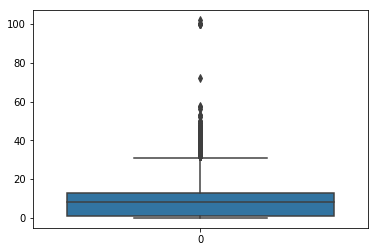

In [38]:
# Se dibuja el boxplot para ver la distribución de los valores:

bxp('VAR_07');

In [39]:
# Se observa el peso de los registros de la variable cuyos valores superiores a 40:

print((A_cat.loc[(A_cat['VAR_07']>40),'VAR_07'].count() / A_cat.shape[0]) * 100)

0.10553437473259872


In [40]:
# Es un 0,10% de los registros, por lo que se opta por eliminarlos:

A_cat = A_cat.loc[(A_cat['VAR_07'] <= 40),:]

#### VAR_106:

Aunque no sea común, esta variable podría tener valores aislados próximos a 100, sin embargo no puede tener un valor menor a 18. 

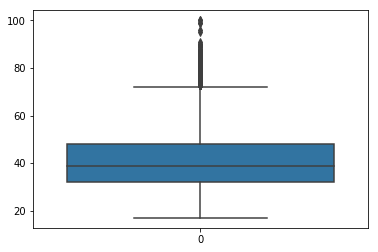

In [41]:
bxp('VAR_106');

In [42]:
# Se observa el peso de los registros de la variable cuyos valores son menores a 0:

print((A_cat.loc[(A_cat['VAR_106'] < 18),'VAR_106'].count() / A_cat.shape[0]) * 100)

0.01142117485818708


In [43]:
# Estos valores supoenen el 0,012% de los registros:

A_cat = A_cat.loc[(A_cat['VAR_106'] != 0),:]

#### VAR_100, VAR_102, VAR_104 Y VAR_105 

Tienen valores extremos pero están informados correctamente, por lo que se decide conservarlos.

### B) Categóricas

**La siguientes funciónes se crean con el objetivo de estudiar la distribución de frecuencias de cada variable categórica.**

- `info_vars()` se crea para analizar los estadísticos básicos de cada variable.
- `dist_freq()` elabora para observar la distribución de cada una de ellas.

Analizando la información proporcionada por ambas funciones se decidirá la forma de actuar sobre cada variable.

A continuación se muestra la lista de variables que se van a analizar:

In [44]:
# Se define la lista de variables categóricas que se quieren observar:

lista_cat = ['VAR_01', 'VAR_02', 'VAR_03', 'VAR_04', 'VAR_05', 'VAR_06', 'VAR_08', 'VAR_09', 'VAR_10', 'VAR_11', 'VAR_14',
             'VAR_15', 'VAR_20', 'VAR_21', 'VAR_23', 'VAR_24', 'VAR_25', 'VAR_26', 'VAR_29', 'VAR_30', 'VAR_31', 'VAR_32',
             'VAR_33', 'VAR_34', 'VAR_36', 'VAR_37', 'VAR_38', 'VAR_39', 'VAR_40', 'VAR_41', 'VAR_42', 'VAR_88', 'VAR_89',
             'VAR_91', 'VAR_92', 'VAR_93', 'VAR_94', 'VAR_95', 'VAR_96', 'VAR_97', 'VAR_98', 'VAR_101','VAR_103']

In [45]:
# Se crea una función que da información básica de las variables categóricas:

def info_vars(x):
    
    print('Información de: ' + A_cat[x].name)
    print('Nº de registros: ' + str(A_cat[x].count()))
    print('Registros únicos: ' + str(A_cat[x].nunique()))
    print('Moda: ' + str(A_cat[x].mode().to_dict()[0]))
    print('Frecuencia de la moda: ' + str(int(round((A_cat.loc[(A_cat[x] == A_cat[x].mode().to_dict()[0]), x].count())\
                                        /(A_cat[x].count())*100))) + str('%'))
    print('Frecuencia media de los registros únicos (excepto la moda): ' + str(int(round((((A_cat[x].count())-\
                                                          (A_cat.loc[(A_cat[x] == A_cat[x].mode().to_dict()[0]), x]\
                                                          .count()))/A_cat[x].nunique())\
                                                          /(A_cat[x].count())*100))) + str('%'))
    print('\n')

In [46]:
# Se crea una función para observar la distribución de frecuencias:

def dist_freq(x):
    var_count = A_cat[x].value_counts()
    sns.set(style="darkgrid")
    sns.barplot(var_count.index, var_count.values, alpha=0.9)
    plt.title('Distribución de frecuencias {}'.format(x))
    plt.ylabel('Ocurrencias', fontsize=12)
    plt.xlabel('', fontsize=12)
    plt.xticks(fontsize=10, rotation='vertical')
    plt.figure(figsize=(12, 8))
    return plt.show()

In [47]:
# Se crea una función que va generando la información básica de cada variable de la lista:

def get_dist_cat():
    for var in lista_cat:
        yield info_vars(var)

gen_dist_cat = get_dist_cat()

In [48]:
# Se crea una función que va generando la distribución de frecuencias de cada variable de la lista:

def get_plot_cat():
    for var in lista_cat:
        yield dist_freq(var)

gen_plot_cat = get_plot_cat()

Información de: VAR_01
Nº de registros: 105068
Registros únicos: 5
Moda: 3
Frecuencia de la moda: 53%
Frecuencia media de los registros únicos (excepto la moda): 9%




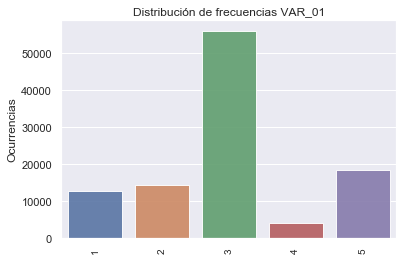

<Figure size 864x576 with 0 Axes>

In [49]:
# Ejecutar para graficar la siguiente variable:

next(gen_dist_cat);next(gen_plot_cat)